In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

### Experiment 1

In [52]:
''' latex format
    \textsf{Референсная модель} & $\mathcal{L}_{total}$ & 0.4894 &   0.3775 &  0.4263 &     0.4824 &    0.3683 & 0 \\
    {} & $\mathcal{L}_{eng}$ & 0.4894 &   0.3775 &  0.4263 &     0.4824 &    0.3683 & 0 \\
    {} & $\mathcal{L}_{pos}$ & 0.4894 &   0.3775 &  0.4263 &     0.4824 &    0.3683 & 0 \\
'''

dir = "raw/exp1"
paths = {
    "eng": "RMSE_E_eng.txt",
    "pos": "RMSE_pos.txt",
    "total": "val_total.txt",
}

shapes = set()

per_model = {}
for loss, path in paths.items():
    with open(os.path.join(dir, path), 'r') as f:
        for line in f:
            _, exp_name, value = line.strip().split()
            _, model, shape = exp_name.split('_')
            if model not in per_model:
                per_model[model] = {}
            if loss not in per_model[model]:
                per_model[model][loss] = {}
            per_model[model][loss][shape] = float(value)

            shapes.add(shape)

shapes = list(shapes)
shapes.sort()

models = [
    "SumModel",
    "LinearModel",
    "MyResnet18",
    "MyCNN",
    "MyViT",
]

for model in models:
    data = per_model[model]
    print("\\textsf{", model, "} & ", "$\mathcal{L}_{\mathsf{total}}$", sep='', end=' ')
    for shape in shapes:
        # print(f"& {data['total'][shape]:0.4f}", end=' ')
        print("& " "$\\mathsf{", f"{data['total'][shape]:0.4f}", "}$", sep='', end=' ')
    print("\\\\")
    print("{} & $\mathcal{L}_{\mathsf{eng}}$", end=' ')
    for shape in shapes:
        # print(f"& {data['eng'][shape]:0.4f}", end=' ')
        print("& " "$\\mathsf{", f"{data['eng'][shape]:0.4f}", "}$", sep='', end=' ')
    print("\\\\")
    print("{} & $\mathcal{L}_{\mathsf{pos}}$", end=' ')
    for shape in shapes:
        # print(f"& {data['pos'][shape]:0.4f}", end=' ')
        print("& " "$\\mathsf{", f"{data['pos'][shape]:0.4f}", "}$", sep='', end=' ')
    print("\\\\")
    if model != models[-1]:
        print("\\midrule")

\textsf{SumModel} & $\mathcal{L}_{\mathsf{total}}$ & $\mathsf{0.1549}$ & $\mathsf{0.1555}$ & $\mathsf{0.1563}$ & $\mathsf{0.1575}$ & $\mathsf{0.1560}$ & $\mathsf{0.1561}$ \\
{} & $\mathcal{L}_{\mathsf{eng}}$ & $\mathsf{0.0213}$ & $\mathsf{0.0221}$ & $\mathsf{0.0226}$ & $\mathsf{0.0229}$ & $\mathsf{0.0220}$ & $\mathsf{0.0222}$ \\
{} & $\mathcal{L}_{\mathsf{pos}}$ & $\mathsf{0.2887}$ & $\mathsf{0.2891}$ & $\mathsf{0.2901}$ & $\mathsf{0.2924}$ & $\mathsf{0.2901}$ & $\mathsf{0.2901}$ \\
\midrule
\textsf{LinearModel} & $\mathcal{L}_{\mathsf{total}}$ & $\mathsf{0.0728}$ & $\mathsf{0.0738}$ & $\mathsf{0.0741}$ & $\mathsf{0.0745}$ & $\mathsf{0.0748}$ & $\mathsf{0.0751}$ \\
{} & $\mathcal{L}_{\mathsf{eng}}$ & $\mathsf{0.0213}$ & $\mathsf{0.0221}$ & $\mathsf{0.0226}$ & $\mathsf{0.0231}$ & $\mathsf{0.0221}$ & $\mathsf{0.0223}$ \\
{} & $\mathcal{L}_{\mathsf{pos}}$ & $\mathsf{0.1244}$ & $\mathsf{0.1258}$ & $\mathsf{0.1257}$ & $\mathsf{0.1264}$ & $\mathsf{0.1278}$ & $\mathsf{0.1282}$ \\
\midrule
\te

### Experiment 2

In [64]:
dir = "raw/exp2"
paths = {
    "eng": "RMSE_E_eng.txt",
    "pos": "RMSE_pos.txt",
}

shapes = set()

per_loss = {}
for metric, path in paths.items():
    with open(os.path.join(dir, path), 'r') as f:
        for line in f:
            _, exp_name, value = line.strip().split()
            fields = exp_name.split('_')
            shape = fields[1]
            loss_fn = fields[2]
            if len(fields) == 4:
                loss_fn += '_' + fields[3]

            if loss_fn not in per_loss:
                per_loss[loss_fn] = {}
            if metric not in per_loss[loss_fn]:
                per_loss[loss_fn][metric] = {}
            per_loss[loss_fn][metric][shape] = float(value)

            shapes.add(shape)

shapes = list(shapes)
shapes.sort()

eng_losses = [
    "RMSE_E",
    "MAE_E",
    "RMSLE",
    "RMSE",
]

def pretty_print(loss_fn: str):
    return loss_fn.replace('_', '/')

for loss_fn in eng_losses:
    data = per_loss[loss_fn]
    print("\\textsf{", pretty_print(loss_fn), "} &", sep='', end=' ')
    print("$\mathcal{L}_{\mathsf{eng}}$", end=' ')
    for shape in shapes:
        print("& " "$\\mathsf{", f"{data['eng'][shape]:0.4f}", "}$", sep='', end=' ')
    print("\\\\")
    print("{} & $\mathcal{L}_{\mathsf{pos}}$", end=' ')
    for shape in shapes:
        print("& " "$\\mathsf{", f"{data['pos'][shape]:0.4f}", "}$", sep='', end=' ')
    print("\\\\")
    if loss_fn != eng_losses[-1]:
        print("\\midrule")

\textsf{RMSE/E} & $\mathcal{L}_{\mathsf{eng}}$ & $\mathsf{0.0194}$ & $\mathsf{0.0198}$ & $\mathsf{0.0201}$ & $\mathsf{0.0192}$ & $\mathsf{0.0193}$ & $\mathsf{0.0195}$ \\
{} & $\mathcal{L}_{\mathsf{pos}}$ & $\mathsf{0.0250}$ & $\mathsf{0.0269}$ & $\mathsf{0.0284}$ & $\mathsf{0.0294}$ & $\mathsf{0.0310}$ & $\mathsf{0.0338}$ \\
\midrule
\textsf{MAE/E} & $\mathcal{L}_{\mathsf{eng}}$ & $\mathsf{0.0198}$ & $\mathsf{0.0200}$ & $\mathsf{0.0204}$ & $\mathsf{0.0199}$ & $\mathsf{0.0199}$ & $\mathsf{0.0200}$ \\
{} & $\mathcal{L}_{\mathsf{pos}}$ & $\mathsf{0.0251}$ & $\mathsf{0.0269}$ & $\mathsf{0.0284}$ & $\mathsf{0.0294}$ & $\mathsf{0.0312}$ & $\mathsf{0.0336}$ \\
\midrule
\textsf{RMSLE} & $\mathcal{L}_{\mathsf{eng}}$ & $\mathsf{0.0193}$ & $\mathsf{0.0196}$ & $\mathsf{0.0204}$ & $\mathsf{0.0191}$ & $\mathsf{0.0194}$ & $\mathsf{0.0194}$ \\
{} & $\mathcal{L}_{\mathsf{pos}}$ & $\mathsf{0.0249}$ & $\mathsf{0.0269}$ & $\mathsf{0.0285}$ & $\mathsf{0.0294}$ & $\mathsf{0.0310}$ & $\mathsf{0.0338}$ \\
\mi

### Experiment 3

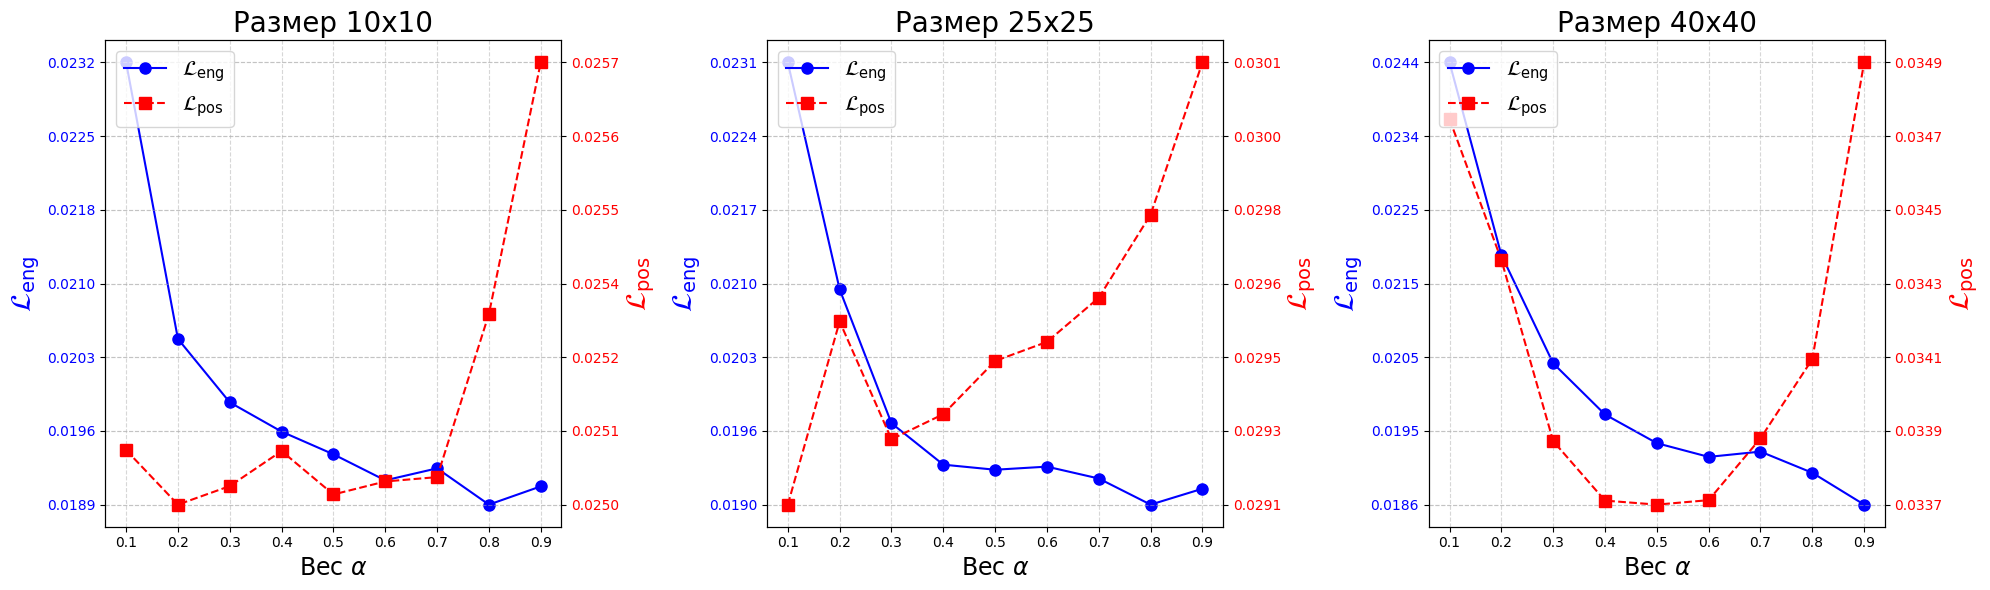

In [19]:
from matplotlib.ticker import FormatStrFormatter

dir = "raw/exp3"
paths = {
    "eng": "RMSE_E_eng.txt",
    "pos": "RMSE_pos.txt",
}

shapes = set()
alphas = set()

data = {key: {} for key in paths.keys()}

for metric, path in paths.items():
    with open(os.path.join(dir, path), 'r') as f:
        for line in f:
            _, exp_name, value = line.strip().split()
            _, shape, alpha = exp_name.split('_')

            alpha = float(alpha)
            value = float(value)

            if shape not in data[metric]:
                data[metric][shape] = {}
            
            data[metric][shape][alpha] = value

            alphas.add(alpha)
            shapes.add(shape)

shapes = list(shapes)
shapes.sort()

alphas = list(alphas)
alphas.sort()

fig, axs = plt.subplots(1, 3, figsize=(20, 6))  # 1 row, 3 columns

for i, (ax1, shape) in enumerate(zip(axs, shapes)):
    arr_eng = sorted(list(data['eng'][shape].items()), key=lambda x: x[0])
    arr_eng = arr_eng[1:-1]

    arr_pos = sorted(list(data['pos'][shape].items()), key=lambda x: x[0])
    arr_pos = arr_pos[1:-1]

    ax1.plot([x[0] for x in arr_eng], [x[1] for x in arr_eng], color='blue', linestyle='-', marker='o', markersize=8, label='$\mathcal{L}_{\mathsf{eng}}$')
    ax1.set_ylabel('$\mathcal{L}_{\mathsf{eng}}$', color='blue', fontsize=20)
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_yticks(np.linspace(np.min([x[1] for x in arr_eng]), np.max([x[1] for x in arr_eng]), 7))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))

    ax2 = ax1.twinx()
    ax2.plot([x[0] for x in arr_pos], [x[1] for x in arr_pos], color='red', linestyle='--', marker='s', markersize=8, label='$\mathcal{L}_{\mathsf{pos}}$')
    ax2.set_ylabel('$\mathcal{L}_{\mathsf{pos}}$', color='red', fontsize=20)
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_yticks(np.linspace(np.min([x[1] for x in arr_pos]), np.max([x[1] for x in arr_pos]), 7))
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))

    ax1.set_xlabel('Вес $\\alpha$', fontsize=17)
    ax1.set_title(f"Размер {shape}", fontsize=20)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=15)

    ax1.grid(which='major', linestyle='--', alpha=0.5)
    ax2.grid(which='major', linestyle='--', alpha=0.5)

# plt.subplots_adjust(wspace=0.5)
plt.tight_layout()

plt.savefig('../graphics/exp3_alpha')
plt.show()

### Experiment 4

In [100]:
dir = "raw/exp4"
paths = {
    "eng": "RMSE_E_eng.txt",
    "pos": "RMSE_pos.txt",
}

all_num_layers = set()
all_num_heads = set()
all_hidden_dim = set()

data = {key: {} for key in paths.keys()}

for metric, path in paths.items():
    with open(os.path.join(dir, path), 'r') as f:
        for line in f:
            _, exp_name, value = line.strip().split()
            _, num_layers, hidden_dim, num_heads = exp_name.split('_')
            num_layers = int(num_layers)
            hidden_dim = int(hidden_dim)
            num_heads = int(num_heads)

            all_num_layers.add(num_layers)
            all_num_heads.add(num_heads)
            all_hidden_dim.add(hidden_dim)


all_num_layers = sorted(list(all_num_layers))
all_num_heads = sorted(list(all_num_heads))
all_hidden_dim = sorted(list(all_hidden_dim))

num_layers_id, num_heads_id, hidden_dim_id = {}, {}, {}

for i, val in enumerate(all_num_layers):
    num_layers_id[val] = i

for i, val in enumerate(all_num_heads):
    num_heads_id[val] = i

for i, val in enumerate(all_hidden_dim):
    hidden_dim_id[val] = i

loss_val = {
    "eng": np.zeros((len(all_num_layers), len(all_num_heads), len(all_hidden_dim))),
    "pos": np.zeros((len(all_num_layers), len(all_num_heads), len(all_hidden_dim))),
}

for metric, path in paths.items():
    with open(os.path.join(dir, path), 'r') as f:
        for line in f:
            _, exp_name, value = line.strip().split()
            _, num_layers, hidden_dim, num_heads = exp_name.split('_')
            num_layers = int(num_layers)
            hidden_dim = int(hidden_dim)
            num_heads = int(num_heads)

            value = float(value)

            loss_val[metric][num_layers_id[num_layers], num_heads_id[num_heads], hidden_dim_id[hidden_dim]] = value

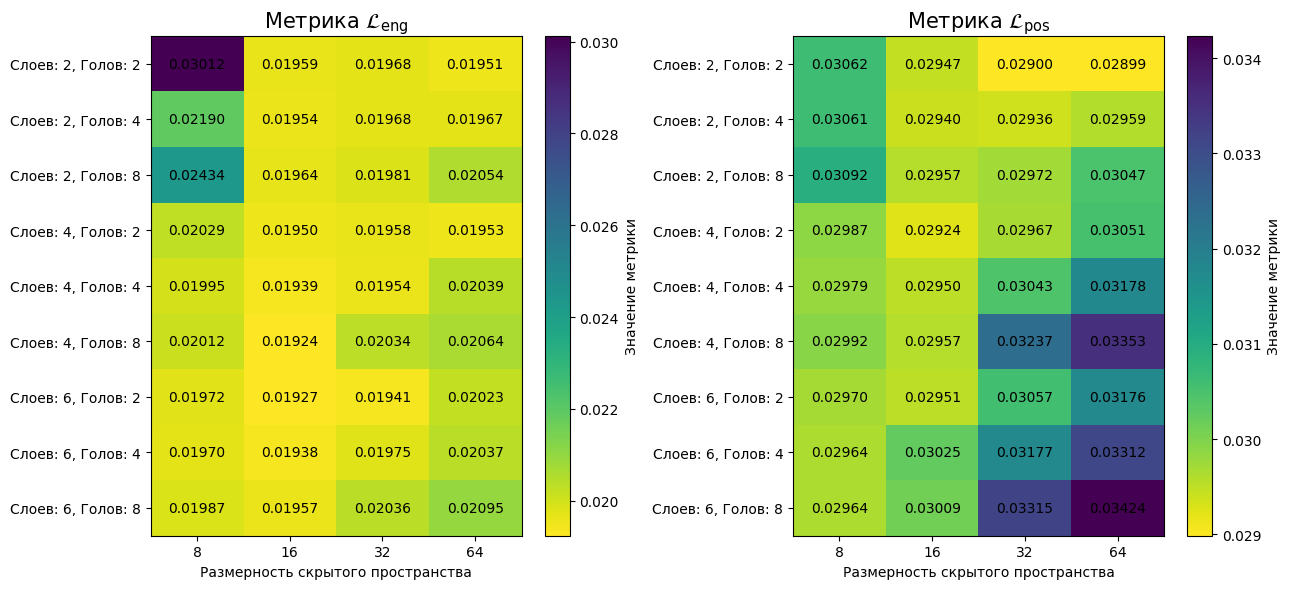

In [132]:
fig, axs = plt.subplots(1, 2, figsize=(13, 6))  # 1 row, 3 columns

for i, (ax, metric) in enumerate(zip(axs, ["eng", "pos"])):
    data = loss_val[metric]

    im = ax.imshow(data.reshape(data.shape[0] * data.shape[1], data.shape[2]), cmap='viridis_r', aspect='auto')

    # Add color bar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.set_label('Значение метрики')

    # Set ticks and labels
    ax.set_xticks(np.arange(data.shape[2]))
    ax.set_yticks(np.arange(data.shape[0] * data.shape[1]))  # Adjusted range for the last row
    ax.set_xticklabels(all_hidden_dim)
    ax.set_yticklabels(['Слоев: {}, Голов: {}'.format(layer, head) for layer in all_num_layers for head in all_num_heads])  # Added an empty label for padding

    # Rotate the tick labels and set their alignment.
    # plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            for k in range(data.shape[2]):
                text = ax.text(k, i * data.shape[1] + j, "{:.5f}".format(data[i, j, k]),
                            ha="center", va="center", color="black")

    metric_name = "$\mathcal{L}_{\mathsf{eng}}$" if metric == "eng" else "$\mathcal{L}_{\mathsf{pos}}$"
    ax.set_title(f"Метрика {metric_name}", fontsize=15)
    ax.set_xlabel('Размерность скрытого пространства')
    # ax.set_ylabel('Number of Layers and Heads')

plt.tight_layout()
plt.savefig('../graphics/exp4_model_params')
plt.show()

### Experiment 5

In [13]:
dir = "raw/exp5"
paths = [
    "train_eng.txt",
    "train_pos.txt",
    "val_eng.txt",
    "val_pos.txt",
]

data = {}

for path in paths:
    dataset_metric, _ = path.split('.')
    dataset, metric = dataset_metric.split('_')
    with open(os.path.join(dir, path), 'r') as f:
        for line in f:
            _, exp_name, value = line.strip().split()
            value = float(value)
            _, shape, use_flip, use_rot = exp_name.split('_')
            use_flip = use_flip == "True"
            use_rot = use_rot == "True"

            data[(shape, dataset, metric, use_flip, use_rot)] = value
            # print(shape, dataset, metric, use_flip, use_rot, value)

augs = [
    (False, False),
    (True, False),
    (False, True),
    (True, True)
]
shapes = ["15x15", "25x25"]
datasets = ["train", "val"]
metrics = ["eng", "pos"]

for use_flip, use_rot in augs:
    if use_flip:
        print('\\cmark & ', sep='', end='')
    else:
        print('\\xmark & ', sep='', end='')
    if use_rot:
        print('\\cmark ', sep='', end='')
    else:
        print('\\xmark ', sep='', end='')
    for shape in shapes:
        for dataset in datasets:
            for metric in metrics:
                print("& " "$\\mathsf{", f"{data[(shape, dataset, metric, use_flip, use_rot)]:0.4f}", "}$", sep='', end=' ')
    print('\\\\')

\xmark & \xmark & $\mathsf{0.0182}$ & $\mathsf{0.0255}$ & $\mathsf{0.0217}$ & $\mathsf{0.0269}$ & $\mathsf{0.0181}$ & $\mathsf{0.0291}$ & $\mathsf{0.0192}$ & $\mathsf{0.0294}$ \\
\cmark & \xmark & $\mathsf{0.0186}$ & $\mathsf{0.0259}$ & $\mathsf{0.0194}$ & $\mathsf{0.0269}$ & $\mathsf{0.0186}$ & $\mathsf{0.0295}$ & $\mathsf{0.0191}$ & $\mathsf{0.0293}$ \\
\xmark & \cmark & $\mathsf{0.0185}$ & $\mathsf{0.0258}$ & $\mathsf{0.0193}$ & $\mathsf{0.0267}$ & $\mathsf{0.0186}$ & $\mathsf{0.0296}$ & $\mathsf{0.0189}$ & $\mathsf{0.0293}$ \\
\cmark & \cmark & $\mathsf{0.0185}$ & $\mathsf{0.0258}$ & $\mathsf{0.0192}$ & $\mathsf{0.0267}$ & $\mathsf{0.0186}$ & $\mathsf{0.0295}$ & $\mathsf{0.0189}$ & $\mathsf{0.0292}$ \\
